In [1]:
##IMPORT
from fit_one_act import PINN_single
import torch
import numpy as np
import pandas as pd
from utilities import xavier_init_routine, xavier_init_routine
import matplotlib.pyplot as plt

# Set training parameters

In [5]:
#####PARAMETERS#####
#plotting
PLOT = 1

#Device
DEVICE = "cpu"

#Optimizer
MAX_ITER_LBFGS = 50000
LINESEARCH =  "strong_wolfe" #"strong_wolfe" or None

#ION Channel properties
E_K = torch.tensor([-96.2], dtype = torch.float64, device = DEVICE)
G_K = torch.tensor([0.1], dtype = torch.float64, device = DEVICE)

#Model
NN_DEPTH = 10
NN_BREADTH = 20

#Training
ADAM_IT = 1000
WHOLE_DATA = False

if ~WHOLE_DATA:
    N_T = 2000 #Training set size
    
EXP_REP = 5 #repetition (activation voltage) to consider


In [6]:
#Build layer list
layers = [1] #nb of inputs
for i in range(NN_DEPTH):  # nb of layers
    layers.append(NN_BREADTH)
layers.append(1) #output size

#import  data
#current
PATH = './experimental_data/Kv1.2/Exp/Kv1.2_2505_rep2_Current.txt'
data =  pd.read_csv(PATH, header=None, delim_whitespace=True)
t = data[0]
Ik =   data[EXP_REP] #

#stim
PATH_act = './experimental_data/Kv1.2/Exp/Kv1.2_2505_rep2_Stimulus.txt'
v_act = pd.read_csv(PATH_act, header=None, delim_whitespace=True).to_numpy().squeeze()
v_train = v_act[EXP_REP]


# Domain bounds
lb = t.min(0)
ub = t.max(0)

# Train

In [7]:
############ TRAINING #############

if WHOLE_DATA:
    #use all the data
    t_train = t
    Ik_train = Ik.to_numpy()

else:
    idx = np.arange(11)  # make sure rise is in training data
    idx = np.concatenate((idx, np.random.choice(t.shape[0], N_T, replace=False)))

    t_train = t[idx].to_numpy()
    Ik_train = Ik[idx].to_numpy()
    
# Build model
model = PINN_single(t_train, Ik_train, layers, lb, ub, v_train, device = DEVICE, max_iter_lbfgs=MAX_ITER_LBFGS)
model.apply(xavier_init_routine)  # initialize nn

# TRAIN
model.train(ADAM_IT)

It: 0, Loss: 1.603e+01
Loss: 4.803e+00
Loss: 8.528e+00
Loss: 4.413e+00
Loss: 4.052e+00
Loss: 3.674e+00
Loss: 3.504e+00
Loss: 3.262e+00
Loss: 2.022e+00
Loss: 1.971e+00
Loss: 1.921e+00
Loss: 1.801e+00
Loss: 1.754e+00
Loss: 1.747e+00
Loss: 1.745e+00
Loss: 1.744e+00
Loss: 1.734e+00
Loss: 1.717e+00
Loss: 1.667e+00
Loss: 1.563e+00
Loss: 2.086e+00
Loss: 1.528e+00
Loss: 1.508e+00
Loss: 1.499e+00
Loss: 1.497e+00
Loss: 1.496e+00
Loss: 1.495e+00
Loss: 1.490e+00
Loss: 1.480e+00
Loss: 1.424e+00
Loss: 1.415e+00
Loss: 1.405e+00
Loss: 1.393e+00
Loss: 1.377e+00
Loss: 1.359e+00
Loss: 1.340e+00
Loss: 1.342e+00
Loss: 1.325e+00
Loss: 1.297e+00
Loss: 1.249e+00
Loss: 1.263e+00
Loss: 1.227e+00
Loss: 1.183e+00
Loss: 1.125e+00
Loss: 9.954e-01
Loss: 8.700e-01
Loss: 1.040e+00
Loss: 6.957e-01
Loss: 5.894e-01
Loss: 5.391e-01
Loss: 4.973e-01
Loss: 4.877e-01
Loss: 4.565e-01
Loss: 4.505e-01
Loss: 4.266e-01
Loss: 3.624e-01
Loss: 2.899e-01
Loss: 2.366e-01
Loss: 2.072e-01
Loss: 1.932e-01
Loss: 1.863e-01


# Plot results


In [52]:
t = np.arange(0,499.5,0.1)

In [10]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple. """

    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

def func(p, t, p_inf, p_tau):
    """ode function"""
    dp = (p_inf - p) / p_tau
    return dp


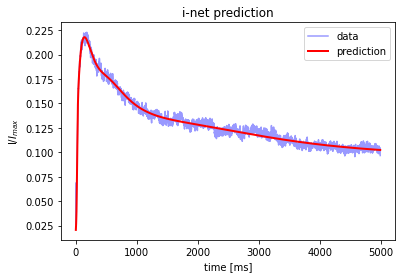

In [11]:
i_pred = model.predict(np.squeeze(t))
i_pred = ((i_pred + 1)*(model.I.max().cpu().detach().numpy() - model.I.min().cpu().detach().numpy())/2+model.I.min().cpu().detach().numpy())

plt.title("i-net prediction")
plt.plot(Ik, label = "data",  color=lighten_color('b', 0.4))

plt.xlabel("time [ms]")
plt.ylabel(r"I/$I_{max}$")
plt.plot(np.squeeze(i_pred), 'r', label = "prediction", linewidth = 2.0)
plt.legend()
plt.savefig("plots/net_pred_exp_data.svg")

plt.show()

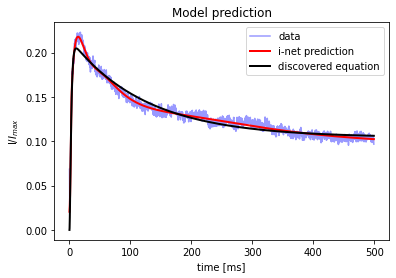

In [14]:
from scipy.integrate import odeint

t = np.arange(0,499.5,0.1)
m_reg = odeint(func, 0, t, args = (model.m_inf.cpu().detach().numpy(), model.m_tau.cpu().detach().numpy()*5))
h_reg = odeint(func, 1, t, args = (model.h_inf.cpu().detach().numpy(), model.h_tau.cpu().detach().numpy()*500))
I_reg =  0.1*m_reg*m_reg*h_reg*(v_act[EXP_REP] - (-96.2))

plt.title(r"Model prediction")
plt.plot(t, Ik, color=lighten_color('b', 0.4), label = "data")
plt.plot(t, np.squeeze(i_pred), 'r', label = "i-net prediction", linewidth = 2.0)
plt.plot(t, np.squeeze(I_reg), 'k', label = "discovered equation", linewidth = 2.0)
plt.legend()
plt.ylabel(r"I/$I_{max}$")
plt.xlabel("time [ms]")
           
plt.savefig("plots/pred_surrogate_noise10.svg")

# MSEs

In [15]:
from torch import nn
loss = nn.MSELoss()
netMSE = loss(torch.Tensor(np.squeeze(i_pred)), torch.Tensor(Ik.to_numpy()))
netMSE

tensor(1.2711e-05)

In [16]:
eqMSE = loss(torch.Tensor(I_reg.squeeze()), torch.Tensor(Ik.to_numpy().squeeze()))
eqMSE

tensor(3.1063e-05)